In [1]:
import torch
import pandas
import matplotlib.pyplot as plt
import torch.nn.functional as F


### Reading the dataset

In [2]:
file=open('/content/drive/MyDrive/building_makemore/names.txt')

In [3]:
words=file.read().split('\n')

In [4]:

len(words)

32033

In [5]:
stoi={c:i+1 for i,c in enumerate(sorted(list(set(''.join(words)))))}
stoi['.']=0
itos={i:c for c,i in stoi.items()}

In [6]:
X=[]
Y=[]
blocksize=3

for w in words[:5]:

  #print(w)
  context=[0]*blocksize
  

  for ch in w+'.':
    
    ix=stoi[ch]
    X.append(context[:])
    Y.append(ix)

    #print(''.join(itos[c] for c in context),'---->',itos[ix])

    
    context.append(ix)
    context=context[1:]
    
   
    
    
 



Taking the first 3 characters and predicting the 4th char

In [7]:
X=torch.tensor(X)
Y=torch.tensor(Y)


In [8]:

X.shape

torch.Size([32, 3])

In [9]:
# We have initialised our embedding matrix
C=torch.randn(27,2)

In [10]:
# We see that we can use a 1d tensor to obtain the embeddings
C[torch.tensor([2,3])]

tensor([[ 0.6386, -1.2907],
        [ 0.4760, -0.1603]])

In [11]:
C[2],C[3]

(tensor([ 0.6386, -1.2907]), tensor([ 0.4760, -0.1603]))

In [12]:
# This means that  all the integers 32*3 are represented by a 1d tensor of size 2
C[X].shape

torch.Size([32, 3, 2])

In [13]:
W1=torch.randn(6,100)
b1=torch.randn(100)

In [14]:
W1.shape

torch.Size([6, 100])

As seen from the below image (taken from Bengio et al. 2003 MLP language model paper), the weight matrix associated with first hidden layer should be of shape (6,any_number_of_choice). lets assume it is (6,100). Our input matrix is of shape (32,3,2). Matrix multiplication cannot happen, we need some manipulation. 6 because, there are 3 characters being input to the model and each is represented by 2 integers. 100 represents the number of neurons in the hidden layer.

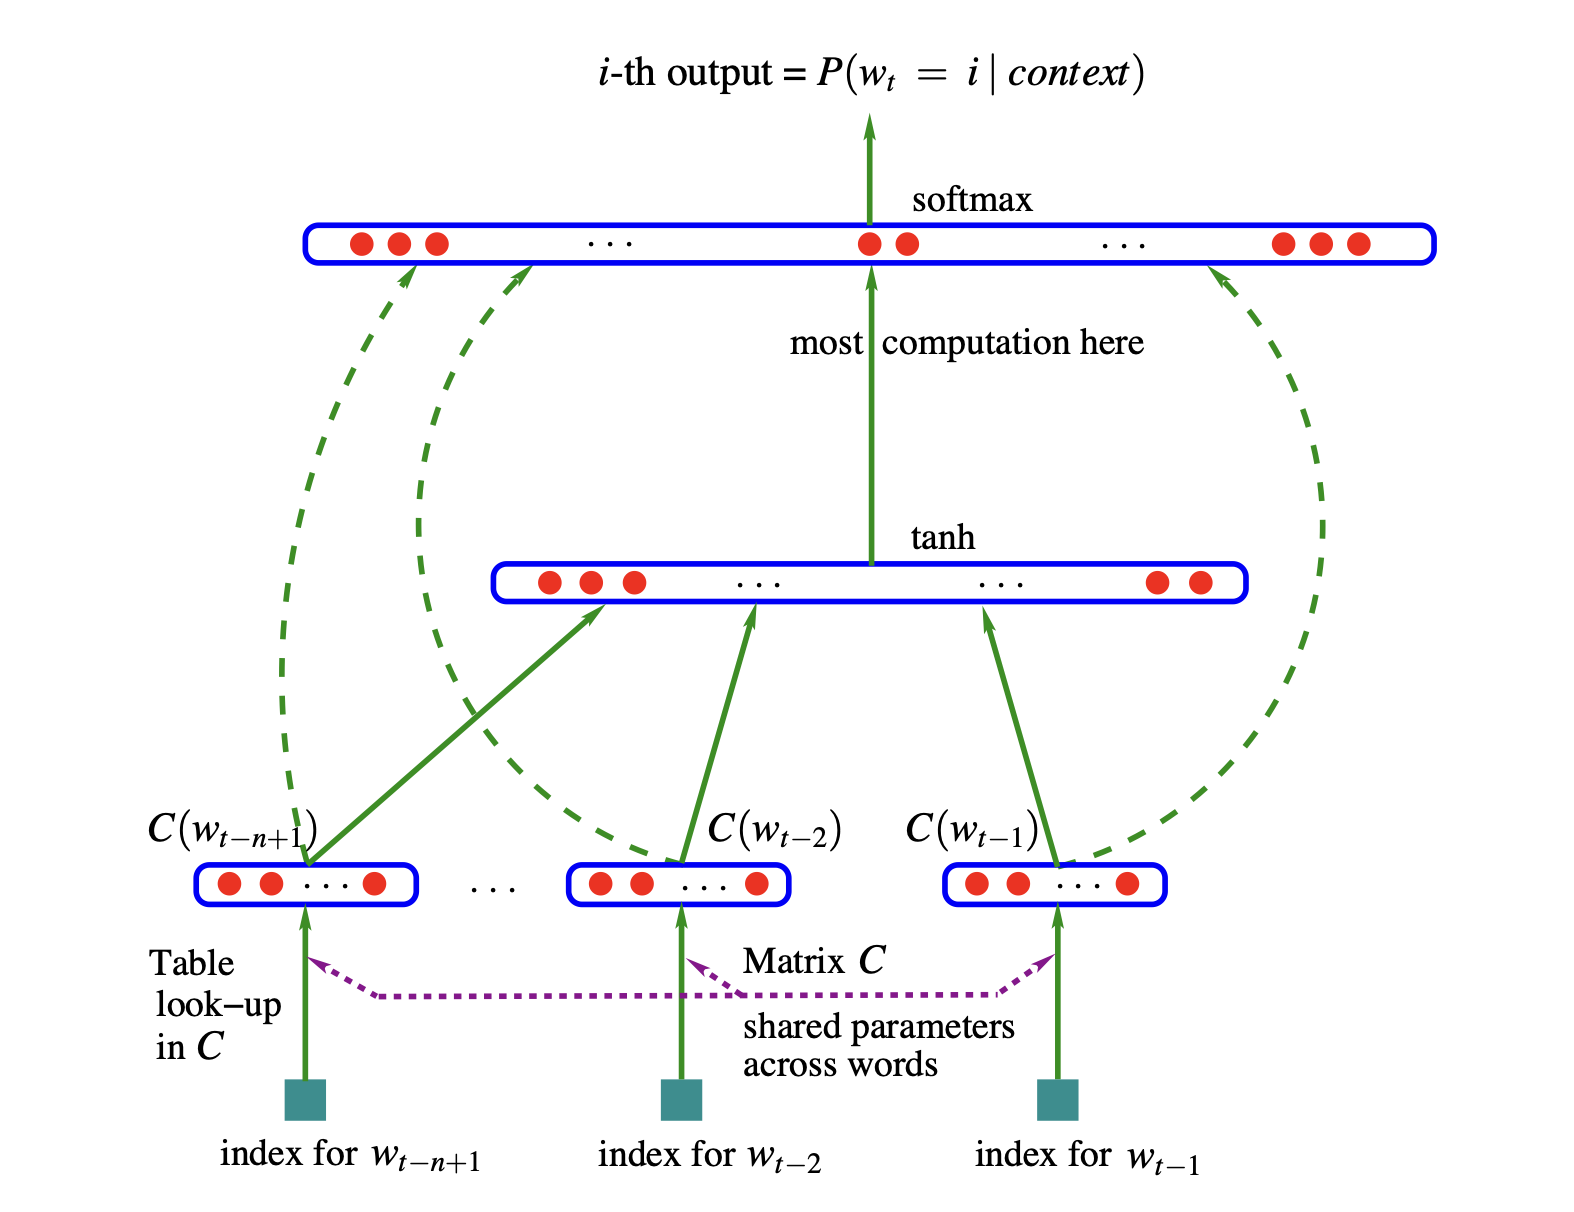

In [15]:
# This is our embedding matrix
emb=C[X]

In [16]:
emb.view(32,6)

tensor([[ 1.3133, -0.8881,  1.3133, -0.8881,  1.3133, -0.8881],
        [ 1.3133, -0.8881,  1.3133, -0.8881,  1.5129,  0.4103],
        [ 1.3133, -0.8881,  1.5129,  0.4103,  0.9508,  0.3595],
        [ 1.5129,  0.4103,  0.9508,  0.3595,  0.9508,  0.3595],
        [ 0.9508,  0.3595,  0.9508,  0.3595, -1.4783,  0.1145],
        [ 1.3133, -0.8881,  1.3133, -0.8881,  1.3133, -0.8881],
        [ 1.3133, -0.8881,  1.3133, -0.8881,  0.4378, -0.4186],
        [ 1.3133, -0.8881,  0.4378, -0.4186, -0.2105, -1.1289],
        [ 0.4378, -0.4186, -0.2105, -1.1289,  0.8886,  0.1230],
        [-0.2105, -1.1289,  0.8886,  0.1230,  1.0435,  1.2921],
        [ 0.8886,  0.1230,  1.0435,  1.2921,  0.8886,  0.1230],
        [ 1.0435,  1.2921,  0.8886,  0.1230, -1.4783,  0.1145],
        [ 1.3133, -0.8881,  1.3133, -0.8881,  1.3133, -0.8881],
        [ 1.3133, -0.8881,  1.3133, -0.8881, -1.4783,  0.1145],
        [ 1.3133, -0.8881, -1.4783,  0.1145,  1.0435,  1.2921],
        [-1.4783,  0.1145,  1.0435,  1.2

In [17]:
# To get the activations for each input from the first hidden layer of 100 neurons

(emb.view(32,6)@W1+b1).shape

torch.Size([32, 100])

This gives us the activations for each of the 100 neurons for each of the 32 inputs

In [18]:
# Adding non linearity to the activations. -1 because we don't want to hard code anything. b1 addition is correct according to the broadcasting rules

h=torch.tanh(emb.view(-1,6)@W1+b1)

### Lets now build the output layer

In [19]:
# 32,27
#  1,27

#according to the broadcasting rules , b2 can be added to h@W2

In [20]:
W2=torch.randn(100,27)
b2=torch.randn(27)


In [21]:
logits=h@W2+b2

In [22]:
logits.shape

torch.Size([32, 27])

In [23]:
counts=logits.exp()

In [24]:
probs=counts/counts.sum(1,keepdims=True)

In [25]:
# We want to maximise the probability our network gives to correct character in Y and hence we will need negative log likelihood loss as below
loss=-probs[torch.arange(32),Y].log().mean()
loss

tensor(13.4475)

***

Putting it all together for first 32 examples in training set

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [28]:
for p in parameters:
  p.requires_grad=True

In [29]:
for _ in range(20):
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  #backward pass
  for p in parameters:
    p.grad=None

  loss.backward()

  for p in parameters:
    p.data+= -0.1*p.grad

17.76971435546875
13.656401634216309
11.298768997192383
9.452455520629883
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652
3.985848903656006
3.6028308868408203
3.2621419429779053
2.961381196975708
2.6982977390289307
2.469712972640991
2.271660327911377
2.101283550262451
1.9571774005889893
1.8374857902526855


We are overfitting now, lots of parameters but training set is very less

****

Doing it for the complete dataset

In [30]:
X=[]
Y=[]
blocksize=3

for w in words:

  #print(w)
  context=[0]*blocksize
  

  for ch in w+'.':
    
    ix=stoi[ch]
    X.append(context[:])
    Y.append(ix)

    #print(''.join(itos[c] for c in context),'---->',itos[ix])

    
    context.append(ix)
    context=context[1:]
    
   

In [31]:
X=torch.tensor(X)
Y=torch.tensor(Y)

In [32]:
C[X[100]]#.shape

tensor([[ 0.0966,  2.0917],
        [ 0.0966,  2.0917],
        [ 0.4303, -1.4163]], grad_fn=<IndexBackward0>)

In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
for p in parameters:
  p.requires_grad=True

In [36]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [37]:
lri = []
lossi = []
stepi = []

In [38]:
# Doing the above over the whole dataset

for i in range(200000):
  # mini batch
  ix=torch.randint(0,X.shape[0],(32,))

  emb = C[X[ix]] 
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad=None

  loss.backward()

  # We have arrived at 0.01 after doing learning rate selection from a range of learning rates. 
  #We can also vary lr and see variation of loss for each mini match. This can help us in deciding the lr
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


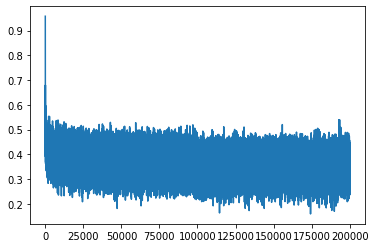

In [39]:
plt.plot(stepi,lossi)

In [40]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2518, grad_fn=<NllLossBackward0>)

****

Converting into training, validation/dev, test set

In [121]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Building the training, validation,test set
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [122]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [123]:
sum(p.nelement() for p in parameters) # number of parameters in total


26967

In [124]:
for p in parameters:
  p.requires_grad=True

In [125]:
lri = []
lossi = []
stepi = []

In [141]:
# Doing the above over the whole dataset

for i in range(200000):
  # mini batch
  ix=torch.randint(0,Xtr.shape[0],(32,))

  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1) 
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  #backward pass
  for p in parameters:
    p.grad=None

  loss.backward()

  # We have arrived at 0.01 after doing learning rate selection from a range of learning rates. 
  #We can also vary lr and see variation of loss for each mini match. This can help us in deciding the lr
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

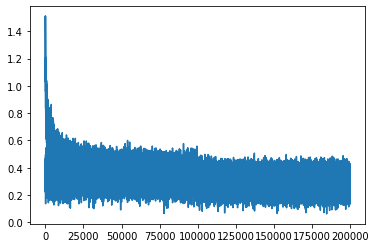

In [142]:
plt.plot(stepi,lossi)

In [143]:
print(loss.item())

1.8330551385879517


In [144]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)

In [145]:
print(loss.item())

2.004009962081909


In [146]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)

In [147]:
print(loss.item())

2.1404335498809814


The training and dev loss have started diverging and hence we can say that the network has started overfitting

****

### Visualising the embedding vectors

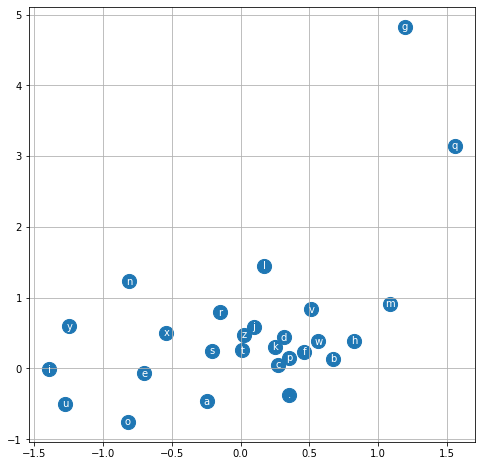

In [120]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

We can see some pattern here

***


### Sampling to generate names

In [148]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 20])

In [149]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahela.
jhori.
kemri.
reet.
khalessa.
jazzmen.
amerynce.
aquie.
ramari.
chaily.
kaleigh.
ham.
poir.
quinthonor.
wal.
adbi.
wajermaisaryn.
kal.
euphleah.
eddeliia.
